In [16]:
import polars as pl
import numpy as np
import os
import json
os.chdir(os.path.expanduser('~/vEcoli'))
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.sparse import csr_matrix

# LB Media Data

## Ground truth data from Outten & O'Halloran, Science, 2001 (https://pubmed.ncbi.nlm.nih.gov/11397910/)

Media type: LB media

Bacterial species: I think based on the 1999 paper they published, it is E. coli strain DH5a

Units used in calculations: Atoms/cell

QUESTIONS/ISSUES: need to confirm if this is the correct strain of E. coli


In [18]:
# load in the "ground truth" data that cyrus collected from Outten & O'Halloran, Science, 2001 (https://pubmed.ncbi.nlm.nih.gov/11397910/): 
GT_data = pd.read_csv("notebooks/mia_notebooks/cofactor_ground_truth_data_from_cyrus_for_mia.csv")
GT_data
# TODO: why is the log_concentration negative here?

,Condition,Below_LOD,Cell,Element,Distance,ScaleDist,ScaleCounts,Error,Log_concentration,Concentration_(M),Atoms/cell
0,Minimal,0,1,MO,138.225817,354.00,9.08603,1000.000000,-5.485784,3.267501e-06,3983.324414
1,Minimal,0,1,ZN,205.106947,354.00,9.08603,55212.922173,-3.785417,1.639017e-04,199808.236064
2,Minimal,0,1,CU,149.815832,354.00,9.08603,1000.000000,-5.191123,6.439870e-06,7850.676467
3,Minimal,1,1,NI,137.331179,354.00,9.08603,1000.000000,-5.508529,3.100778e-06,3780.077086
4,Minimal,1,1,CO,103.448109,354.00,9.08603,1000.000000,-6.369963,4.266155e-07,520.075813
5,Minimal,0,1,FE,203.321486,354.00,9.08603,24669.603524,-3.830810,1.476353e-04,179978.374255
6,Minimal,0,1,MN,135.088853,354.00,9.08603,1000.000000,-5.565538,2.719333e-06,3315.067378
7,Minimal,0,1,CR,122.171244,354.00,9.08603,1000.000000,-5.893951,1.276582e-06,1556.247155
8,Minimal,0,1,V,113.253635,354.00,9.08603,1000.000000,-6.120670,7.574077e-07,923.335846
9,Rich,0,1,MO,146.248788,353.14,9.30606,1000.000000,-5.272756,5.336351e-06,10797.032626


In [25]:
# LB media data from GT data: 
GT_lb_data = GT_data[9:]
GT_lb_df = pl.DataFrame(GT_lb_data[["Element","Atoms/cell"]])
GT_lb_df = GT_lb_df.with_columns(pl.col("Atoms/cell").log10().alias("GT_lb_log_APC"))

# replace the element names with the column names for merging later:
col_names = ["Mo", "Zn", "Cu", "Ni", "Co", "Fe", "Mn", "Cr", "V"]
GT_lb_df = GT_lb_df.with_columns(pl.col("Element").replace(pl.col("Element"), col_names).alias("Element"))
GT_lb_df

Element,Atoms/cell,GT_lb_log_APC
str,f64,f64
"""Mo""",10797.032626,4.033304
"""Zn""",399640.415582,5.601669
"""Cu""",87576.66829,4.942388
"""Ni""",3240.269333,3.510581
"""Co""",443.558908,2.646951
"""Fe""",607143.184501,5.783291
"""Mn""",46743.626407,4.669722
"""Cr""",3414.351358,3.533308
"""V""",249.432594,2.396953


## LB media data from Huynh et al., 2022 fig 1c and 1d (https://journals.asm.org/doi/full/10.1128/spectrum.01006-21): 

Media type: LB media

Bacterial species: E. coli K-12 BW25113

Units used in calculations: Atoms/CFU

QUESTIONS/ISSUES: double check that I did my web plot analyzer stuff right when I do it for the minimal media conditions

In [75]:
# load in LB media data from Huynh et al., 2022 fig 1c (https://journals.asm.org/doi/full/10.1128/spectrum.01006-21): 
LBM_1C = pd.read_excel("notebooks/mia_notebooks/Huynh_2022_F1C_LB_media_data.xlsx")
# load in LB media from Huynh et al., 2022 fig 1d LB (https://journals.asm.org/doi/full/10.1128/spectrum.01006-21): 
LBM_1D = pd.read_excel("notebooks/mia_notebooks/Huynh_2022_F1D_LB_media_data.xlsx")

# convert data frames to polars data frames and rename the columns to be more descriptive: 
LBM_1C_df = pl.DataFrame(LBM_1C[["metal","atoms/CFU (non-log scale option)"]])
LBM_1C_df = LBM_1C_df.with_columns(pl.col("atoms/CFU (non-log scale option)").alias("LBM_Huynh_log_APC"))

LBM_1D_df = pl.DataFrame(LBM_1D[["metal","atoms/CFU (non-log scale option)"]])
LBM_1D_df = LBM_1D_df.with_columns(pl.col("atoms/CFU (non-log scale option)").alias("LBM_Huynh_log_APC"))

# add the rows from LBM_1D to the bottom of LBM_1C:
LBM_F1_2022_df = LBM_1C_df.vstack(LBM_1D_df)
LBM_F1_2022_df

metal,atoms/CFU (non-log scale option),LBM_Huynh_log_APC
str,f64,f64
"""Mn""",3.557895,3.557895
"""Fe""",5.793684,5.793684
"""Cu""",4.581053,4.581053
"""Zn""",4.543158,4.543158
"""V""",2.708245,2.708245
"""Cr""",4.232558,4.232558
"""Co""",1.983087,1.983087
"""Ni""",3.389006,3.389006


## LB media data from Budhraja, et al., 2019 Fig 1 (https://academic.oup.com/metallomics/article/11/5/925/5962190#supplementary-data):

Media type: LB media

Bacterial species: I think E. coli strain BW25113, but I could be wrong

Units used in calculations: Atoms/cell

QUESTIONS/ISSUES: need to confirm if this is the correct strain of E. coli!!!!!

In [82]:
# data from Budhraja, et al., 2019 Fig 1 (https://academic.oup.com/metallomics/article/11/5/925/5962190#supplementary-data): 
LBM_F1_2019 = pd.read_excel("notebooks/mia_notebooks/Budhraja_2019_F1_data.xlsx")
LBM_F1_2019

,metal,metal ions per cell (ranging from 1000 to 1E+09),Upper error,lower error,metal ions per cell (using 3 to 9 as the axis only),raise to ten,Upper Error,Lower Error,10^ (col E)
0,Mo,1.455079e+04,1.497124e+04,1.414215e+04,4.166667,1.467799e+04,4.179012,4.154321,1.467799e+04
1,Ni,1.394215e+04,1.475952e+04,1.317006e+04,4.148148,1.406527e+04,4.172840,4.123457,1.406527e+04
2,Co,3.261385e+03,3.502111e+03,2.994254e+03,3.518519,3.300035e+03,3.549383,3.481481,3.300035e+03
3,Fe,2.038348e+06,2.157847e+06,1.953087e+06,6.308642,2.035363e+06,6.333333,6.290123,2.035363e+06


In [34]:
# todo this is the original way I was grabbing the data for this graph, but I now do not think this axis calibration was the right one to go with. 
# LB media from second paper:
LBM_F1_2019_df = pl.DataFrame(LBM_F1_2019[["metal","metal ions per cell (ranging from 1000 to 1E+09)"]])
# add the log of the metal ions per cell to the data frame:
LBM_F1_2019_df = LBM_F1_2019_df.with_columns(pl.col("metal ions per cell (ranging from 1000 to 1E+09)").log10().alias("LBM_Budhraja_log_APC"))
LBM_F1_2019_df

metal,metal ions per cell (ranging from 1000 to 1E+09),LBM_Budhraja_log_APC
str,f64,f64
"""Mo""",14550.790838,4.162887
"""Ni""",13942.154688,4.14433
"""Co""",3261.384943,3.513402
"""Fe""",2.0383e6,6.309278


In [84]:
# TODO ask cyrus if he believes this is the correct option for the metal ions per cell data? I feel like this has to be it, but again the axes calibration is really tripping me up. 
# LB media from second paper:
LBM_F1_2019_df = pl.DataFrame(LBM_F1_2019[["metal","raise to ten"]])
# add the log of the metal ions per cell to the data frame:
LBM_F1_2019_df = LBM_F1_2019_df.with_columns(pl.col("raise to ten").log10().alias("LBM_Budhraja_log_APC"))
LBM_F1_2019_df

metal,raise to ten,LBM_Budhraja_log_APC
str,f64,f64
"""Mo""",14677.992676,4.166667
"""Ni""",14065.272421,4.148148
"""Co""",3300.034791,3.518519
"""Fe""",2.0354e6,6.308642


## data from Umemura et al., 2017, table 11.2 (https://link.springer.com/chapter/10.1007/978-4-431-56463-8_11)

Media type: LB media

Bacterial species: E. coli MG1655

Units used in calculations: Atoms/cell

QUESTIONS/ISSUES: do I need table 11.3?

In [85]:
# data from Umemura et al., 2017, table 11.2 (https://link.springer.com/chapter/10.1007/978-4-431-56463-8_11): 
LBM_T112_2017 = pd.read_excel("notebooks/mia_notebooks/Umemura_2017_T112_data.xlsx")

# transform into a polars data frame and rename the columns:
LBM_T112_2017_df = pl.DataFrame(LBM_T112_2017[["Symbol","E. coli\xa0MG1655 in LB"]])
LBM_T112_2017_df = LBM_T112_2017_df.with_columns(pl.col("E. coli\xa0MG1655 in LB").log10().alias("LBM_Umemura_T112_log_APC"))
LBM_T112_2017_df

Symbol,E. coli MG1655 in LB,LBM_Umemura_T112_log_APC
str,f64,f64
"""Mg""",7.5e7,7.875061
"""P""",4.2e8,8.623249
"""S""",1.7e8,8.230449
"""K""",2.6e8,8.414973
"""Ca""",6.2e6,6.792392
…,…,…
"""Au""",0.25,-0.60206
"""Tl""",45.0,1.653213
"""Pb""",60.0,1.778151


## LB media data from Nies & Herzberg, 2012: https://onlinelibrary.wiley.com/doi/full/10.1111/mmi.12123 / Kristen et al., 2011: https://journals.asm.org/doi/full/10.1128/jb.05293-11

Media type: LB media

Bacterial species: E. coli W3110 

Units used in calculations: Atoms/cell

QUESTIONS/ISSUES: 

In [112]:
# LB media data from Nies et al., 2012: https://onlinelibrary.wiley.com/doi/full/10.1111/mmi.12123
Nies_2012 = pd.read_excel("notebooks/mia_notebooks/Nies_2012_T1_data.xlsx")
Nies_2012 = pl.DataFrame(Nies_2012[["Element", "Atoms/cell"]])
N_2012 = Nies_2012.with_columns(pl.col("Atoms/cell").log10().alias("E. coli W3110 (Nies & Herzberg, 2012)"))
N_2012

Element,Atoms/cell,"E. coli W3110 (Nies & Herzberg, 2012)"
str,f64,f64
"""Mg""",1.27e7,7.103804
"""Ca""",2.0500e6,6.311754
"""Fe""",290000.0,5.462398
"""Co""",4500.0,3.653213
"""Ni""",9700.0,3.986772
"""Zn""",114000.0,5.056905
"""Mn""",11700.0,4.068186
"""Mo""",3450.0,3.537819
"""Cu""",169000.0,5.227887


In [127]:
# Create a data frame of all the data that overlaps with the ground truth data
overlap_element_names = ["Fe", "Mn", "Zn", "Cu", "Co", "Ni", "Mo", "V", "Cr"]

# Select and filter relevant data from each source based on what I have ground truth data for:
H_2022 = LBM_F1_2022_df.select(["metal", "LBM_Huynh_log_APC"]).filter(pl.col("metal").is_in(overlap_element_names))
B_2019 = LBM_F1_2019_df.select(["metal", "LBM_Budhraja_log_APC"]).filter(pl.col("metal").is_in(overlap_element_names))
U_T112 = LBM_T112_2017_df.select(["Symbol", "LBM_Umemura_T112_log_APC"]).filter(pl.col("Symbol").is_in(overlap_element_names))
N_2012 = N_2012.select(["Element", "E. coli W3110 (Nies & Herzberg, 2012)"]).filter(pl.col("Element").is_in(overlap_element_names))

# Rename the 'Symbol' column in U_T112 to 'Element' for consistency
H_2022 = H_2022.rename({"metal": "Element"})
B_2019 = B_2019.rename({"metal": "Element"})
U_T112 = U_T112.rename({"Symbol": "Element"})

# Ensure unique column names before joining
H_2022 = H_2022.rename({"LBM_Huynh_log_APC": "E. coli K-12 BW25113 (Huynh et al., 2022)"})
B_2019 = B_2019.rename({"LBM_Budhraja_log_APC": "E. coli strain? (Budhraja et al., 2019)"})
U_T112 = U_T112.rename({"LBM_Umemura_T112_log_APC": "E. coli MG1655 (Umemura et al., 2017)"})

# Perform outer joins to combine the DataFrames
lb_exp_data = H_2022.join(B_2019, on="Element", how="left")
lb_exp_data = lb_exp_data.join(U_T112, on="Element", how="left")
lb_exp_data = lb_exp_data.join(N_2012, on="Element", how="left")

# Combine all data with Ground Truth data: 
GT_lb = GT_lb_df.select(["Element", "GT_lb_log_APC"])
GT_lb = GT_lb.rename({"GT_lb_log_APC": "E. coli DH5$\\alpha$ (Outten & O'Halloran, 2001 (GT Data))"})
lb_df = GT_lb.join(lb_exp_data, on="Element", how="inner")

# elongate the polars dataframe:
df_long = lb_df.melt(id_vars=["Element"], variable_name="Data Source", value_name="log$_{10}$(Atoms/Cell)")
# Convert to Pandas DataFrame
df_long_pd = df_long.to_pandas()

# show the df: 
lb_df

/var/folders/fg/mh5y1dgn2n5ft000p664m2z80000gq/T/ipykernel_6617/3688230658.py:21: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  lb_exp_data = H_2022.join(B_2019, on="Element", how="left")
/var/folders/fg/mh5y1dgn2n5ft000p664m2z80000gq/T/ipykernel_6617/3688230658.py:22: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  lb_exp_data = lb_exp_data.join(U_T112, on="Element", how="left")
/var/folders/fg/mh5y1dgn2n5ft000p664m2z80000gq/T/ipykernel_6617/3688230658.py:23: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  lb_exp_data = lb_exp_data.join(N_2012, on="Elem

Element,"E. coli DH5$\alpha$ (Outten & O'Halloran, 2001 (GT Data))","E. coli K-12 BW25113 (Huynh et al., 2022)","E. coli strain? (Budhraja et al., 2019)","E. coli MG1655 (Umemura et al., 2017)","E. coli W3110 (Nies & Herzberg, 2012)"
str,f64,f64,f64,f64,f64
"""Zn""",5.601669,4.543158,null,5.812913,5.056905
"""Cu""",4.942388,4.581053,null,4.778151,5.227887
"""Ni""",3.510581,3.389006,4.148148,4.113943,3.986772
"""Co""",2.646951,1.983087,3.518519,3.740363,3.653213
"""Fe""",5.783291,5.793684,6.308642,6.518514,5.462398
"""Mn""",4.669722,3.557895,null,5.278754,4.068186
"""Cr""",3.533308,4.232558,null,3.778151,null
"""V""",2.396953,2.708245,null,3.50515,null


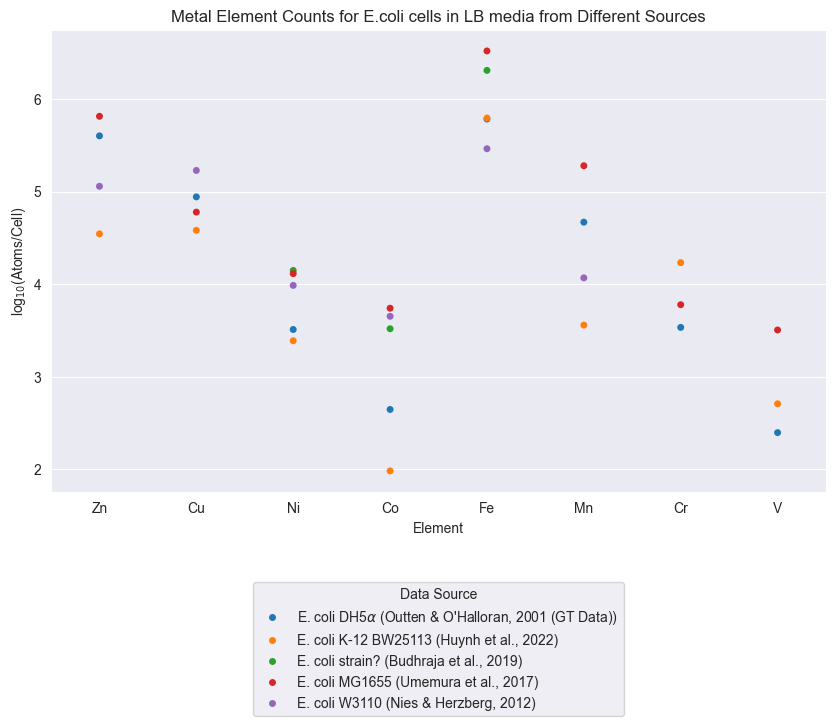

In [128]:
# Create the vertical strip plot
plt.figure(figsize=(10, 6))
ax = sns.stripplot(data=df_long_pd, y="log$_{10}$(Atoms/Cell)", x="Element", hue="Data Source", jitter=False)
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.5))
plt.title("Metal Element Counts for E.coli cells in LB media from Different Sources")
plt.show()

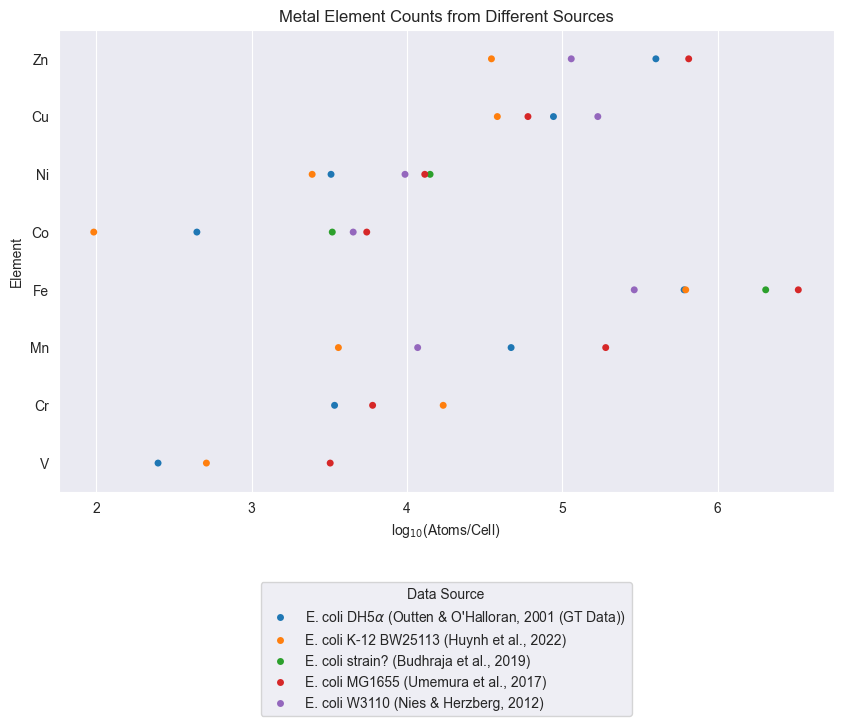

In [129]:
# create the horizontal stripplot:
plt.figure(figsize=(10, 6))
ax = sns.stripplot(data=df_long_pd, x="log$_{10}$(Atoms/Cell)", y="Element", hue="Data Source", jitter=False)
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.5))
plt.title("Metal Element Counts from Different Sources")
plt.show()

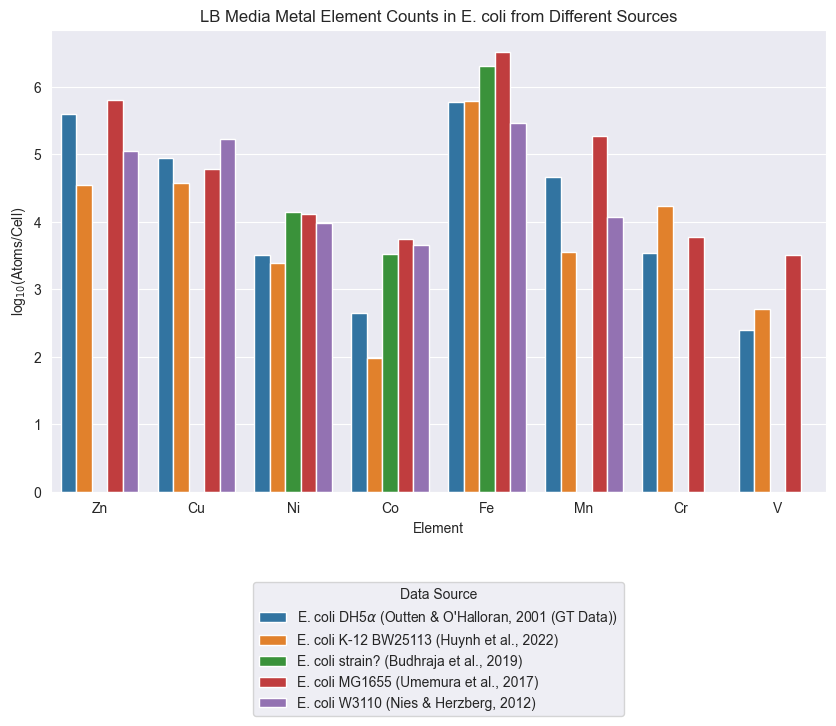

In [130]:
# create a bar plot of the metal counts data: 
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_long_pd, x="Element", y="log$_{10}$(Atoms/Cell)", hue="Data Source")
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.5))
plt.title("LB Media Metal Element Counts in E. coli from Different Sources")
plt.show()

## template

Media type: LB media

Bacterial species:

Units used in calculations:

QUESTIONS/ISSUES:

## More LB media sources (that have more varying conditions)

In [31]:
# LB media from Saenkham-Huntsinger et al., 2024 (https://journals.asm.org/doi/full/10.1128/mbio.03522-23):
SH_F2A_2024 = pd.read_excel("notebooks/mia_notebooks/Saenkham_2024_F2a_data.xlsx")
SH_F2A_2024 = pl.DataFrame(SH_F2A_2024)
SH_F2A_2024
# TODO: find if there is a WT tested???

Element,CFT073/pGEN,yhiM/pGEN,yhim_yhim
str,f64,f64,f64
"""Cu""",114.675768,77.8157,135.153584
"""Fe""",821.25,615.0,1023.75
"""Mn""",22.0,19.4,47.4
"""Zn""",780.0,772.5,1087.5


Unnamed: 0,CFT073/pGEN,yhiM/pGEN,yhim_yhim
str,f64,f64,f64
"""Cu""",1136.986301,369.863014,1397.260274
"""Fe""",766.917293,514.285714,917.293233
"""Mn""",609.022556,796.992481,996.240602
"""Zn""",2675.0,1025.0,2562.5


In [ ]:
# todo do the other LB media papers here! and consider doing one with the + Cu media?

In [ ]:
# add the log of the metal ions per cell to the data frame:
# TODO edit this for the new LB data
LBM_F1_2019_df = LBM_F1_2019_df.with_columns(pl.col("metal ions per cell (ranging from 1000 to 1E+09)").log10().alias("LBM_Budhraja_log_APC"))
LBM_F1_2019_df

# Select and filter relevant data from each source
H_2022 = LBM_F1_2022_df.select(["metal", "LBM_Huynh_log_APC"]).filter(pl.col("metal").is_in(overlap_element_names))
B_2019 = LBM_F1_2019_df.select(["metal", "LBM_Budhraja_log_APC"]).filter(pl.col("metal").is_in(overlap_element_names))
U_T112 = LBM_T112_2017_df.select(["Symbol", "LBM_Umemura_T112_log_APC"]).filter(pl.col("Symbol").is_in(overlap_element_names))

# Rename the 'Symbol' column in U_T112 to 'Element' for consistency
H_2022 = H_2022.rename({"metal": "Element"})
B_2019 = B_2019.rename({"metal": "Element"})
U_T112 = U_T112.rename({"Symbol": "Element"})

# Ensure unique column names before joining
H_2022 = H_2022.rename({"LBM_Huynh_log_APC": "Huynh et al., 2022"})
B_2019 = B_2019.rename({"LBM_Budhraja_log_APC": "Budhraja et al., 2019"})
U_T112 = U_T112.rename({"LBM_Umemura_T112_log_APC": "Umamura et al., 2017"})

## Minimal Media Plots with more of the data sources: 

In [57]:
# MOPS data from LaVoie et al., 2015: https://link.springer.com/article/10.1007/s00775-015-1303-1/figures/4
LaVoie_F4_2015 = pd.read_excel("notebooks/mia_notebooks/LaVoie_2015_F4_data.xlsx")
LaVoie_F4_2015
# minimal media data from LaVoie:
MOPS_LaVoie_2015 = pl.DataFrame(LaVoie_F4_2015[["Element","unexposed"]])
MOPS_LaVoie_2015 = MOPS_LaVoie_2015.rename({"unexposed": "MOPS_LaVoie_log_APC"})
# TODO: figure out if this is already in the correct log transformed format
MOPS_LaVoie_2015


Element,MOPS_LaVoie_log_APC
str,f64
"""Mg""",7.339623
"""Mn""",4.450135
"""Fe""",5.894879
"""Co""",3.975741
"""Ni""",3.609164
"""Cu""",4.277628
"""Zn""",4.838275


In [63]:
# M9 media from Umamura et al., 2017, table 11.2:  https://link.springer.com/chapter/10.1007/978-4-431-56463-8_11
# todo figure out if i need to be dividinig by something in table 11.3??? I think I do? 
M9_T112_2017_df = pl.DataFrame(LBM_T112_2017[["Symbol","E. coli\xa0MG1655 in M9"]])
M9_T112_2017_df = M9_T112_2017_df.with_columns(pl.col("E. coli\xa0MG1655 in M9").log10().alias("M9_Umemura_T112_log_APC"))
M9_T112_2017_df

Symbol,E. coli MG1655 in M9,M9_Umemura_T112_log_APC
str,f64,f64
"""Mg""",1.1e8,8.041393
"""P""",5.6e8,8.748188
"""S""",1.5e8,8.176091
"""K""",4.2e8,8.623249
"""Ca""",3.8e6,6.579784
…,…,…
"""Au""",null,null
"""Tl""",null,null
"""Pb""",120.0,2.079181


In [58]:
# load in the data from Yan et al., 2019, figure 1A (https://www.sciencedirect.com/science/article/pii/S002192582030538X?via%3Dihub#sec1):
Xu_F1A_2019 = pd.read_excel("notebooks/mia_notebooks/Xu_2019_F1A_data.xlsx")
MOPS_Xu_2019 = pl.DataFrame(Xu_F1A_2019[["Element","Intracellular metal content (per cell) in No Zn(II) supplement"]])
MOPS_Xu_2019 = MOPS_Xu_2019.with_columns(pl.col("Intracellular metal content (per cell) in No Zn(II) supplement").log10().alias("MOPS_Xu_log_APC"))
MOPS_Xu_2019

Element,Intracellular metal content (per cell) in No Zn(II) supplement,MOPS_Xu_log_APC
str,i64,f64
"""Zn""",140000,5.146128
"""Fe""",380000,5.579784
"""Mn""",32000,4.50515
"""Ni""",3000,3.477121
"""Cu""",20000,4.30103


In [59]:
# Samonella cells in M9 Media from Osman, et al., 2019: https://www.nature.com/articles/s41589-018-0211-4#Sec24
Osman_ST3_2019 = pd.read_excel("notebooks/mia_notebooks/Osman_2019_ST3_data.xlsx")
Osman_ST3_2019
#TODO: ask cyrus if the "metals exposed" data is something we also want to plot?
# Osman minimal media data: 
M9_Osman_2019 = pl.DataFrame(Osman_ST3_2019[["Element","Total Metal (atoms/cell), Control"]])
M9_Osman_2019 = M9_Osman_2019.with_columns(pl.col("Total Metal (atoms/cell), Control").log10().alias("M9_Osman_log_APC"))
M9_Osman_2019

Element,"Total Metal (atoms/cell), Control",M9_Osman_log_APC
str,i64,f64
"""Mg""",26000000,7.414973
"""Mn""",160000,5.20412
"""Fe""",200000,5.30103
"""Co""",900,2.954243
"""Zn""",190000,5.278754
"""Ni""",4600,3.662758
"""Cu""",5100,3.70757


In [60]:
# load in data from Beauchene 2014: https://asset.library.wisc.edu/1711.dl/LE7AB2DFQKDIP8O/R/file-1aa76.pdf
Beauchene_T2_2014 = pd.read_excel("notebooks/mia_notebooks/Beauchene_2014_T2_2_data.xlsx")
Beauchene_T2_2014

,Element,Aerobic Growth (µg/mL cell lysate),Standard Error,Anaerobic Growth (µg/mL cell lysate),Standard Error.1,Aerobic/Araerobic\nFold-Change
0,Mn,1.066,0.084,0.029,0.001,36.6
1,Co,0.070,0.008,0.013,0.000,5.5
2,Ni,0.012,0.001,0.007,0.002,1.7
3,Zn,2.143,0.050,1.341,0.024,1.6
4,Mg,139.169,1.723,105.962,1.016,1.3
5,P,1052.066,10.473,880.023,3.144,1.2
6,S,556.084,9.182,512.049,5.556,1.1
7,Fe,6.306,0.371,7.508,0.087,0.8
8,K,332.128,12.840,516.316,3.029,0.6
9,Cu,0.163,0.010,0.270,0.046,0.6


In [ ]:
# minimal media data from Beauchene (aerobic conditions)
MOPS_aerobic_Beauchene_2014 = pl.DataFrame(Beauchene_T2_2014[["Aerobic Growth (µg/mL cell lysate)"]])
MOPS_aerobic_Beauchene_2014 = MOPS_aerobic_Beauchene_2014.with_columns((pl.col("Aerobic Growth (µg/mL cell lysate)") * .000001).alias("MOPS_aerobic_Beauchene"))
MOPS_aerobic_Beauchene_2014  = MOPS_aerobic_Beauchene_2014.with_columns((pl.col("MOPS_aerobic_Beauchene") / .333 ).alias("MOPS_aerobic_Beauchene_log_APC"))

avogadro_number = 6.022e23  # atoms/mol
# TODO mia double check these values with cyrus. ask if he would want the dry weight or wet weight of E. coli:
cell_mass = 1e-12  # g (average mass of a dry E. coli cell according to https://ecmdb.ca/e_coli_stats)
number_of_cells = 1e6  # number of cells (e.g., 10^6 CFU)
# todo: I know i have to use each elements molecular mass here, but I also need to know the total mass of cells or the volume of the cell lysate to convert this to atoms/cell.. ask cyrus if he has any ideas on how to estimate these properly 13,140 or 13,190 

In [68]:
# minimal media data from GT data: 
GT_mm_data = GT_data[:9]
GT_mm_df = pl.DataFrame(GT_mm_data[["Element","Atoms/cell"]])
GT_mm_df = GT_mm_df.with_columns(pl.col("Atoms/cell").log10().alias("GT_mm_log_APC"))

# replace the element names with the column names:
col_names = ["Mo", "Zn", "Cu", "Ni", "Co", "Fe", "Mn", "Cr", "V"]
GT_mm_df = GT_mm_df.with_columns(pl.col("Element").replace(pl.col("Element"), col_names).alias("Element"))
GT_mm_df

Element,Atoms/cell,GT_mm_log_APC
str,f64,f64
"""Mo""",3983.324414,3.600246
"""Zn""",199808.236064,5.300613
"""Cu""",7850.676467,3.894907
"""Ni""",3780.077086,3.577501
"""Co""",520.075813,2.716067
"""Fe""",179978.374255,5.25522
"""Mn""",3315.067378,3.520492
"""Cr""",1556.247155,3.192079
"""V""",923.335846,2.96536


In [69]:
# add the log of the metal ions per cell to the data frame:
# TODO edit this for the new minimal media data

# Select and filter relevant data from each source
L_2015 = MOPS_LaVoie_2015.select(["Element", "MOPS_LaVoie_log_APC"]).filter(pl.col("Element").is_in(overlap_element_names))
U_2017 = M9_T112_2017_df.select(["Symbol", "M9_Umemura_T112_log_APC"]).filter(pl.col("Symbol").is_in(overlap_element_names))
X_2019 = MOPS_Xu_2019.select(["Element", "MOPS_Xu_log_APC"]).filter(pl.col("Element").is_in(overlap_element_names))
O_2019 = M9_Osman_2019.select(["Element", "M9_Osman_log_APC"]).filter(pl.col("Element").is_in(overlap_element_names))
#todo add beauchene data here!!!
# Rename the 'Symbol' column in U_T112 to 'Element' for consistency
U_2017 = U_2017.rename({"Symbol": "Element"})

# Ensure unique column names before joining
L_2015 = L_2015.rename({"MOPS_LaVoie_log_APC": "E. coli K-12 MG1655 in MOPS (LaVoie et al., 2015)"})
U_2017 = U_2017.rename({"M9_Umemura_T112_log_APC": "E. coli K-12 MG1655 in M9 (Umemura et al., 2017)"})
X_2019 = X_2019.rename({"MOPS_Xu_log_APC": "E. coli MG1655 in MOPS (Xu et al., 2019)"})
O_2019 = O_2019.rename({"M9_Osman_log_APC": "Salmonella in M9 (Osman et al., 2019)"})

# Perform outer joins to combine the DataFrames
mm_exp_data = L_2015.join(U_2017, on="Element", how="left")
mm_exp_data = mm_exp_data.join(X_2019, on="Element", how="left")
mm_exp_data = mm_exp_data.join(O_2019, on="Element", how="left")
mm_exp_data

/var/folders/fg/mh5y1dgn2n5ft000p664m2z80000gq/T/ipykernel_6617/627330177.py:20: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  mm_exp_data = L_2015.join(U_2017, on="Element", how="left")
/var/folders/fg/mh5y1dgn2n5ft000p664m2z80000gq/T/ipykernel_6617/627330177.py:21: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  mm_exp_data = mm_exp_data.join(X_2019, on="Element", how="left")
/var/folders/fg/mh5y1dgn2n5ft000p664m2z80000gq/T/ipykernel_6617/627330177.py:22: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  mm_exp_data = mm_exp_data.join(O_2019, on="Element

Element,"E. coli K-12 MG1655 in MOPS (LaVoie et al., 2015)","E. coli K-12 MG1655 in M9 (Umemura et al., 2017)","E. coli MG1655 in MOPS (Xu et al., 2019)","Salmonella in M9 (Osman et al., 2019)"
str,f64,f64,f64,f64
"""Mn""",4.450135,4.643453,4.50515,5.20412
"""Fe""",5.894879,6.079181,5.579784,5.30103
"""Co""",3.975741,3.342423,null,2.954243
"""Ni""",3.609164,4.20412,3.477121,3.662758
"""Cu""",4.277628,4.845098,4.30103,3.70757
"""Zn""",4.838275,5.69897,5.146128,5.278754


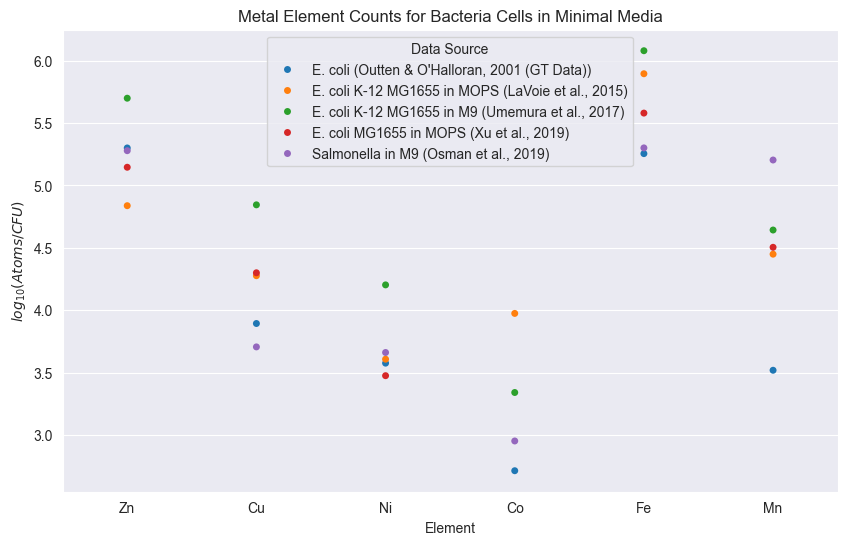

In [72]:
# Combine all minimal media data: 
GT_mm = GT_mm_df.select(["Element", "GT_mm_log_APC"])
GT_mm = GT_mm.rename({"GT_mm_log_APC": "E. coli (Outten & O'Halloran, 2001 (GT Data))"})
mm_df = GT_mm.join(mm_exp_data, on="Element", how="inner")

# Melt the Polars DataFrame to long format
df_mm_long = mm_df.melt(id_vars=["Element"], variable_name="Data Source", value_name="$log_{10}(Atoms/CFU)$")
# Convert to Pandas DataFrame
df_mm_long_pd = df_mm_long.to_pandas()

# Create the strip plot
plt.figure(figsize=(10, 6))
sns.stripplot(data=df_mm_long_pd, y="$log_{10}(Atoms/CFU)$", x="Element", hue="Data Source", jitter=False)
plt.title("Metal Element Counts for Bacteria Cells in Minimal Media")
plt.show()

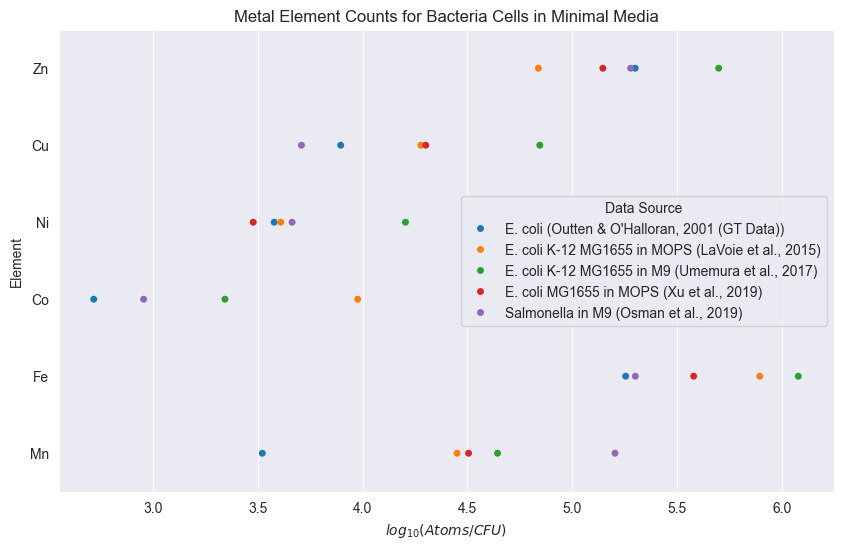

In [73]:
# other orientation: 
plt.figure(figsize=(10, 6))
sns.stripplot(data=df_mm_long_pd, x="$log_{10}(Atoms/CFU)$", y="Element", hue="Data Source", jitter=False)
plt.title("Metal Element Counts for Bacteria Cells in Minimal Media")
plt.show()

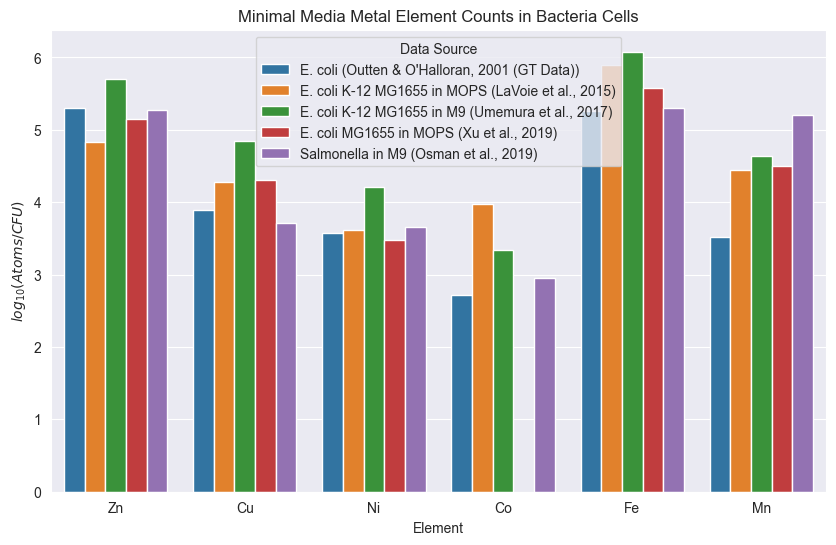

In [74]:
# create a bar plot of the metal counts data: 
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.barplot(data=df_mm_long_pd, x="Element", y="$log_{10}(Atoms/CFU)$", hue="Data Source")
plt.title("Minimal Media Metal Element Counts in Bacteria Cells")
plt.show()

# Minimal media plots 

In [23]:
# the rich media from this paper is made rich by the fact that there is a little bit of Zn in it:
# TODO ask cyrus if this is the right data to use for rich media (or minimal instead)
Zn_Xu_2019 = pl.DataFrame(Xu_F1A_2019[["Element","Intracellular metal content (per cell) in 0.1 mM Zn(II)"]])
Zn_Xu_2019 = Zn_Xu_2019.with_columns(pl.col("Intracellular metal content (per cell) in 0.1 mM Zn(II)").log10().alias("Zn_Xu_log_APC"))
Zn_Xu_2019

Element,Intracellular metal content (per cell) in 0.1 mM Zn(II),Zn_Xu_log_APC
str,f64,f64
"""Zn""",4.9,0.690196
"""Fe""",4.8,0.681241
"""Mn""",3.5,0.544068
"""Ni""",0.3,-0.522879
"""Cu""",1.4,0.146128


In [24]:
# Samonella cells in M9 Media from Osman, et al., 2019: https://www.nature.com/articles/s41589-018-0211-4#Sec24
Osman_ST3_2019 = pd.read_excel("notebooks/mia_notebooks/Osman_2019_ST3_data.xlsx")
Osman_ST3_2019
#TODO: ask cyrus if the "metals exposed" data is something we also want to plot?
# Osman minimal media data: 
M9_Osman_2019 = pl.DataFrame(Osman_ST3_2019[["Element","Total Metal (atoms/cell), Control"]])
M9_Osman_2019 = M9_Osman_2019.with_columns(pl.col("Total Metal (atoms/cell), Control").log10().alias("M9_Osman_log_APC"))
M9_Osman_2019

,Element,"Total Metal (atoms/cell), Control","Total Metal (atoms/cell), Metal Exposed"
0,Mg,26000000,0.0
1,Mn,160000,180000.0
2,Fe,200000,970000.0
3,Co,900,35600.0
4,Zn,190000,230000.0
5,Ni,4600,27400.0
6,Cu,5100,242600.0


In [25]:
# Osman minimal media data: 
M9_Osman_2019 = pl.DataFrame(Osman_ST3_2019[["Element","Total Metal (atoms/cell), Control"]])
M9_Osman_2019 = M9_Osman_2019.with_columns(pl.col("Total Metal (atoms/cell), Control").log10().alias("M9_Osman_log_APC"))
M9_Osman_2019

Element,"Total Metal (atoms/cell), Control",M9_Osman_log_APC
str,i64,f64
"""Mg""",26000000,7.414973
"""Mn""",160000,5.20412
"""Fe""",200000,5.30103
"""Co""",900,2.954243
"""Zn""",190000,5.278754
"""Ni""",4600,3.662758
"""Cu""",5100,3.70757


In [26]:
# load in LaVoie Data from: https://link.springer.com/article/10.1007/s00775-015-1303-1
LaVoie_F4_2015 = pd.read_excel("notebooks/mia_notebooks/LaVoie_2015_F4_data.xlsx")
LaVoie_F4_2015
# minimal media data from LaVoie:
MOPS_LaVoie_2015 = pl.DataFrame(LaVoie_F4_2015[["Element","unexposed"]])
MOPS_LaVoie_2015 = MOPS_LaVoie_2015.rename({"unexposed": "MOPS_LaVoie_log_APC"})
# TODO: figure out if this is already in the correct log transformed format
MOPS_LaVoie_2015

,Element,unexposed,40 µM PMA,160 µM MT,16 µM HgCl2,80 µM HgCl2
0,Mg,7.339623,7.382749,7.469003,7.506739,7.339623
1,Mn,4.450135,4.234501,4.730458,3.932615,4.423181
2,Fe,5.894879,5.700809,5.808625,5.851752,5.700809
3,Co,3.975741,3.927224,3.932615,3.867925,3.932615
4,Ni,3.609164,4.148248,3.846361,3.711590,3.544474
5,Cu,4.277628,4.471698,4.514825,4.563342,4.277628
6,Zn,4.838275,4.795148,5.204852,4.843666,4.730458


In [27]:
# minimal media data from LaVoie:
MOPS_LaVoie_2015 = pl.DataFrame(LaVoie_F4_2015[["Element","unexposed"]])
MOPS_LaVoie_2015 = MOPS_LaVoie_2015.rename({"unexposed": "MOPS_LaVoie_log_APC"})
# TODO: figure out if this is already in the correct log transformed format
MOPS_LaVoie_2015

Element,MOPS_LaVoie_log_APC
str,f64
"""Mg""",7.339623
"""Mn""",4.450135
"""Fe""",5.894879
"""Co""",3.975741
"""Ni""",3.609164
"""Cu""",4.277628
"""Zn""",4.838275


In [34]:
# load in data from Beauchene 2014: https://asset.library.wisc.edu/1711.dl/LE7AB2DFQKDIP8O/R/file-1aa76.pdf
Beauchene_T2_2014 = pd.read_excel("notebooks/mia_notebooks/Beauchene_2014_T2_2_data.xlsx")
Beauchene_T2_2014

,Element,Aerobic Growth (µg/mL cell lysate),Standard Error,Anaerobic Growth (µg/mL cell lysate),Standard Error.1,Aerobic/Araerobic\nFold-Change
0,Mn,1.066,0.084,0.029,0.001,36.6
1,Co,0.070,0.008,0.013,0.000,5.5
2,Ni,0.012,0.001,0.007,0.002,1.7
3,Zn,2.143,0.050,1.341,0.024,1.6
4,Mg,139.169,1.723,105.962,1.016,1.3
5,P,1052.066,10.473,880.023,3.144,1.2
6,S,556.084,9.182,512.049,5.556,1.1
7,Fe,6.306,0.371,7.508,0.087,0.8
8,K,332.128,12.840,516.316,3.029,0.6
9,Cu,0.163,0.010,0.270,0.046,0.6


In [40]:
# minimal media data from Beauchene (aerobic conditions)
MOPS_aerobic_Beauchene_2014 = pl.DataFrame(Beauchene_T2_2014[["Aerobic Growth (µg/mL cell lysate)"]])
MOPS_aerobic_Beauchene_2014 = MOPS_aerobic_Beauchene_2014.with_columns((pl.col("Aerobic Growth (µg/mL cell lysate)") * .000001).alias("MOPS_aerobic_Beauchene"))
MOPS_aerobic_Beauchene_2014  = MOPS_aerobic_Beauchene_2014.with_columns((pl.col("MOPS_aerobic_Beauchene") / .333 ).alias("MOPS_aerobic_Beauchene_log_APC"))

avogadro_number = 6.022e23  # atoms/mol
# TODO mia double check these values
cell_mass = 1e-12  # g (average mass of a single bacterial cell)
number_of_cells = 1e6  # number of cells (e.g., 10^6 CFU)
# todo: I know i have to use each elements molecular mass here, but I also need to know the total mass of cells or the volume of the cell lysate to convert this to atoms/cell.. ask cyrus if he has any ideas on how to estimate these properly 13,140 or 13,190 

In [41]:
MOPS_aerobic_Beauchene_2014


Aerobic Growth (µg/mL cell lysate),MOPS_aerobic_Beauchene
f64,f64
1.066,0.000001
0.07,7.0000e-8
0.012,1.2000e-8
2.143,0.000002
139.169,0.000139
…,…
556.084,0.000556
6.306,0.000006
332.128,0.000332


In [ ]:
# Create a data frame of all the data that overlaps with the ground truth data
overlap_element_names = ["Fe", "Mn", "Zn", "Cu", "Co", "Ni", "Mo", "V", "Cr"]

# Select and filter relevant data from each source
X_MOPS_2019 = MOPS_Xu_2019.select(["Element", "MOPS_Xu_log_APC"]).filter(pl.col("Element").is_in(overlap_element_names))
X_Zn_MOPS_2019 = Zn_Xu_2019.select(["Element", "Zn_Xu_log_APC"]).filter(pl.col("Element").is_in(overlap_element_names))
O_M9_2019 = M9_Osman_2019.select(["Element", "M9_Osman_log_APC"]).filter(pl.col("Element").is_in(overlap_element_names))
L_MOPS_2015 = MOPS_LaVoie_2015.select(["Element", "MOPS_LaVoie_log_APC"]).filter(pl.col("Element").is_in(overlap_element_names))

H_2022 = LBM_F1_2022_df.select(["metal", "LBM_Huynh_log_APC"]).filter(pl.col("metal").is_in(overlap_element_names))
B_2019 = LBM_F1_2019_df.select(["metal", "LBM_Budhraja_log_APC"]).filter(pl.col("metal").is_in(overlap_element_names))
U_T112 = LBM_T112_2017_df.select(["Symbol", "LBM_Umemura_T112_log_APC"]).filter(pl.col("Symbol").is_in(overlap_element_names))

# Rename the 'Symbol' column in U_T112 to 'Element' for consistency
H_2022 = H_2022.rename({"metal": "Element"})
B_2019 = B_2019.rename({"metal": "Element"})
U_T112 = U_T112.rename({"Symbol": "Element"})

# Ensure unique column names before joining
H_2022 = H_2022.rename({"LBM_Huynh_log_APC": "Huynh et al., 2022"})
B_2019 = B_2019.rename({"LBM_Budhraja_log_APC": "Budhraja et al., 2019"})
U_T112 = U_T112.rename({"LBM_Umemura_T112_log_APC": "Umamura et al., 2017"})

# Perform outer joins to combine the DataFrames
lb_exp_data = H_2022.join(B_2019, on="Element", how="left")
lb_exp_data = lb_exp_data.join(U_T112, on="Element", how="left")
lb_exp_data
hello = 2